In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [2]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)


In [3]:
class BaseModel:
    def __init__(self, D):
        self.w = np.random.randn(D) / np.sqrt(D)

    def partial_fit(self, input_, target, eligibility, lr=1e-2):
        self.w += lr*(target - input_.dot(self.w))*eligibility

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.w)

In [4]:

class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        self.eligibilities = np.zeros((env.action_space.n, feature_transformer.dimensions))
        for i in range(env.action_space.n):
            model = BaseModel(feature_transformer.dimensions)
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform([s])
        result = np.stack([m.predict(X) for m in self.models]).T
        return result

    def update(self, s, a, G, gamma, lambda_):
        X = self.feature_transformer.transform([s])
        self.eligibilities *= gamma*lambda_
        self.eligibilities[a] += X[0]
        self.models[a].partial_fit(X[0], G, self.eligibilities[a])

    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [5]:
def play_one(model, env, eps, gamma, lambda_):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    # while not done and iters < 200:
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)

        # update the model
        Q = model.predict(observation)
        G = reward + gamma*np.max(Q[0])
        model.update(prev_observation, action, G, gamma, lambda_)

        totalreward += reward
        iters += 1

    return totalreward

[2021-03-31 20:00:15,825] Making new env: MountainCar-v0
/home/ali/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


episode: 0 total reward: -200.0
episode: 100 total reward: -112.0
episode: 200 total reward: -144.0
episode: 300 total reward: -91.0
episode: 400 total reward: -90.0
episode: 500 total reward: -132.0
episode: 600 total reward: -104.0
episode: 700 total reward: -132.0
episode: 800 total reward: -133.0
episode: 900 total reward: -135.0
episode: 1000 total reward: -158.0
episode: 1100 total reward: -136.0
episode: 1200 total reward: -146.0
episode: 1300 total reward: -139.0
episode: 1400 total reward: -93.0
episode: 1500 total reward: -154.0
episode: 1600 total reward: -200.0
episode: 1700 total reward: -141.0
episode: 1800 total reward: -141.0
episode: 1900 total reward: -200.0
episode: 2000 total reward: -143.0
episode: 2100 total reward: -143.0
episode: 2200 total reward: -200.0
episode: 2300 total reward: -200.0
episode: 2400 total reward: -148.0
episode: 2500 total reward: -200.0
episode: 2600 total reward: -144.0
episode: 2700 total reward: -146.0
episode: 2800 total reward: -200.0


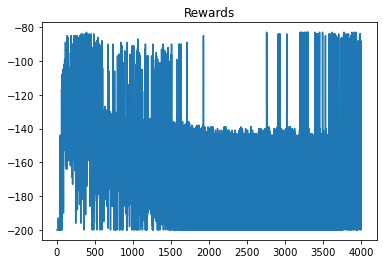

In [6]:
env = gym.make('MountainCar-v0')
ft = FeatureTransformer(env)
model = Model(env, ft, "constant")
N = 4000
gamma = 0.99
lambda_ = 0.7
totalrewards = np.empty(N)
for n in range(N):
    eps = 0.1*(0.97**n)
    totalreward = play_one(model, env, eps, gamma, lambda_)
    totalrewards[n] = totalreward
    if n%100 == 0:
        print("episode:", n, "total reward:", totalreward)
    
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", -totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()